In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import os
import pandas as pd
import math
import seaborn as sns
import cmasher as cmr

from scipy.special import logsumexp
from pathlib import Path
from tqdm.auto import tqdm, trange

from bge_score_jax import BGe

/home/zj448/.conda/envs/jax/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
dags_compressed = np.load('/data/zj448/exact_posteriors/dags_7.npy')
dags_compressed.shape

(1138779265, 7)

In [3]:
def compute_exact_posterior(dags_compressed, observations, batch_size=1, verbose=True):
    num_variables = observations.shape[1]
    model = BGe(num_variables=num_variables)

    @jax.jit
    def log_prob(observations, adjacencies_compressed):
        adjacencies = jnp.unpackbits(adjacencies_compressed, axis=1, count=num_variables ** 2)
        adjacencies = adjacencies.reshape(-1, num_variables, num_variables)

        v_log_prob = jax.vmap(model.log_prob, in_axes=(None, 0))
        log_probs = v_log_prob(observations, adjacencies)
        return jnp.sum(log_probs, axis=1)

    num_dags = dags_compressed.shape[0]
    log_probs = np.zeros((num_dags,), dtype=np.float32)
    for i in trange(0, num_dags, batch_size, disable=(not verbose)):
        # Get a batch of (compressed) DAGs
        batch_compressed = dags_compressed[i:i + batch_size]

        # Compute the BGe scores
        log_probs[i:i + batch_size] = log_prob(observations, batch_compressed)

    # Normalize the log-marginal probabilities
    log_probs = log_probs - logsumexp(log_probs)
    return log_probs


def edge_log_marginal(dags_compressed, log_joint, num_variables, batch_size=1, verbose=True):
    @jax.jit
    def marginalize(log_probs, adjacencies_compressed):
        adjacencies = jnp.unpackbits(adjacencies_compressed, axis=1, count=num_variables ** 2)
        log_probs = jnp.where(adjacencies == 1, log_probs[:, None], -jnp.inf)
        return jax.nn.logsumexp(log_probs, axis=0)

    num_dags = dags_compressed.shape[0]
    log_marginal = []
    for i in trange(0, num_dags, batch_size, disable=(not verbose)):
        # Get a batch of data
        batch_compressed = dags_compressed[i:i + batch_size]
        log_probs = log_joint[i:i + batch_size]

        log_marginal.append(marginalize(log_probs, batch_compressed))

    log_marginal = np.stack(log_marginal, axis=0)
    log_marginal = logsumexp(log_marginal, axis=0)
    return log_marginal.reshape(num_variables, num_variables)

In [29]:
datasets = ['ell', 'len', 'spr']
dfs, observations = {}, {}

keys=['M_BH','log_sigma0','log_R_e_sph_eq_kpc','log<Sigma>_e','GJC23log(M*,gal/M_sun)','GJC23log(sSFR)','GJC23W2-W3']
std_keys=['M_BH_std_sym','log_sigma0_std','log_R_e_sph_eq_kpc_std','log<Sigma>_e_std','GJC23log(M*,gal/M_sun)_std','GJC23log(sSFR)_std','GJC23W2-W3_std']


np.random.seed(0)
for dataset in datasets:
    dfs[dataset] = pd.read_csv(f'R_e_data/causal_BH_{dataset}_std.csv')
    # sampling from 1 sigma observation error
    df_sampled=pd.DataFrame()
    for key,std_key in zip(keys,std_keys):
        df_sampled[key]=dfs[dataset][key]+np.random.randn(len(dfs[dataset]))*dfs[dataset][std_key]
    dfs[dataset] = df_sampled.copy()
    # standardize data
    dfs[dataset] = dfs[dataset].apply(lambda col: ( col - col.mean() ) / col.std(), axis=0)  # Standardize data
    observations[dataset] = np.asarray(dfs[dataset])

In [37]:
root = Path('/home/zj448/causal/jax-dag-gflownet/exact_posteriors')

log_edge_marginals = {}
log_joint = {}
for dataset in datasets:
    log_joint[dataset] = compute_exact_posterior(dags_compressed, observations[dataset], batch_size=2048)
    log_edge_marginals[dataset] = edge_log_marginal(dags_compressed,
        log_joint[dataset], observations[dataset].shape[1], batch_size=4096)

100%|██████████| 278023/278023 [00:21<00:00, 13000.21it/s]


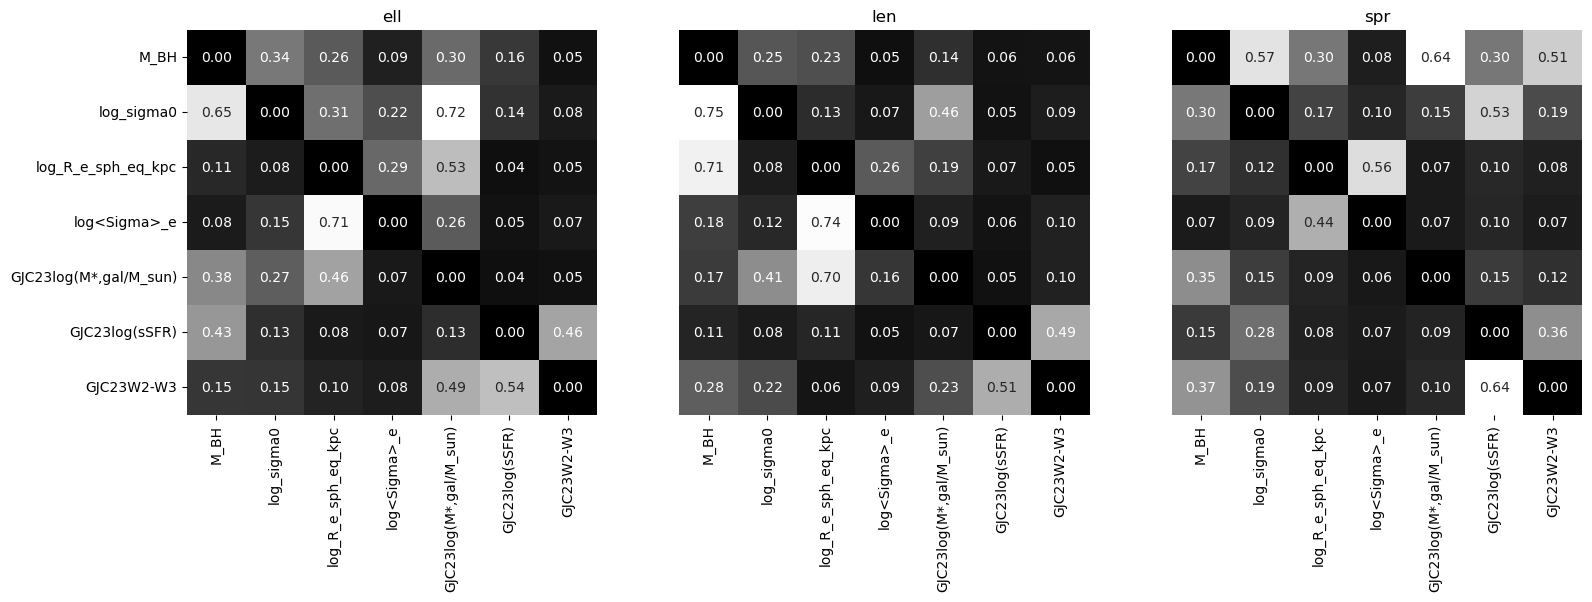

In [38]:
plt.figure(figsize=(18, 5))

for i, dataset in enumerate(datasets):
    ax = plt.subplot2grid((1, 3), (0, i))
    log_edge_marginal = log_edge_marginals[dataset]
    edge_marginal = pd.DataFrame(np.exp(log_edge_marginal),
        index=dfs[dataset].columns, columns=dfs[dataset].columns)

    sns.heatmap(edge_marginal, cmap='gray', ax=ax,
                annot=edge_marginal, fmt='.2f', cbar=False,
               yticklabels=i == 0)
    ax.set_title(dataset)
#plt.savefig('figures/edge_marginals.png', dpi=300)
plt.show()

In [39]:
def get_transitive_closure(adjacency):
    # Warshall's algorithm
    def scan_fun(closure, i):
        outer_product = jnp.outer(closure[:, i], closure[i])
        return (jnp.logical_or(closure, outer_product), None)
    
    adjacency = adjacency.astype(jnp.bool_)
    arange = jnp.arange(adjacency.shape[0])
    closure, _ = jax.lax.scan(scan_fun, adjacency, arange)

    return closure

def path_log_marginal(dags_compressed, log_joint, num_variables, batch_size=1, verbose=True):
    @jax.jit
    def marginalize(log_probs, adjacencies_compressed):
        adjacencies = jnp.unpackbits(adjacencies_compressed, axis=1, count=num_variables ** 2)
        adjacencies = adjacencies.reshape(-1, num_variables, num_variables)
        closures = jax.vmap(get_transitive_closure)(adjacencies)
        log_probs = jnp.where(closures, log_probs[:, None, None], -jnp.inf)
        return jax.nn.logsumexp(log_probs, axis=0)

    num_dags = dags_compressed.shape[0]
    log_marginal = []
    for i in trange(0, num_dags, batch_size, disable=(not verbose)):
        # Get a batch of data
        batch_compressed = dags_compressed[i:i + batch_size]
        log_probs = log_joint[i:i + batch_size]

        log_marginal.append(marginalize(log_probs, batch_compressed))

    log_marginal = np.stack(log_marginal, axis=0)
    log_marginal = logsumexp(log_marginal, axis=0)
    return log_marginal.reshape(num_variables, num_variables)

In [40]:
log_path_marginals = {}
for dataset in datasets:
    log_path_marginals[dataset] = path_log_marginal(dags_compressed,
        log_joint[dataset], observations[dataset].shape[1], batch_size=1024)

100%|██████████| 1112090/1112090 [02:33<00:00, 7243.79it/s]


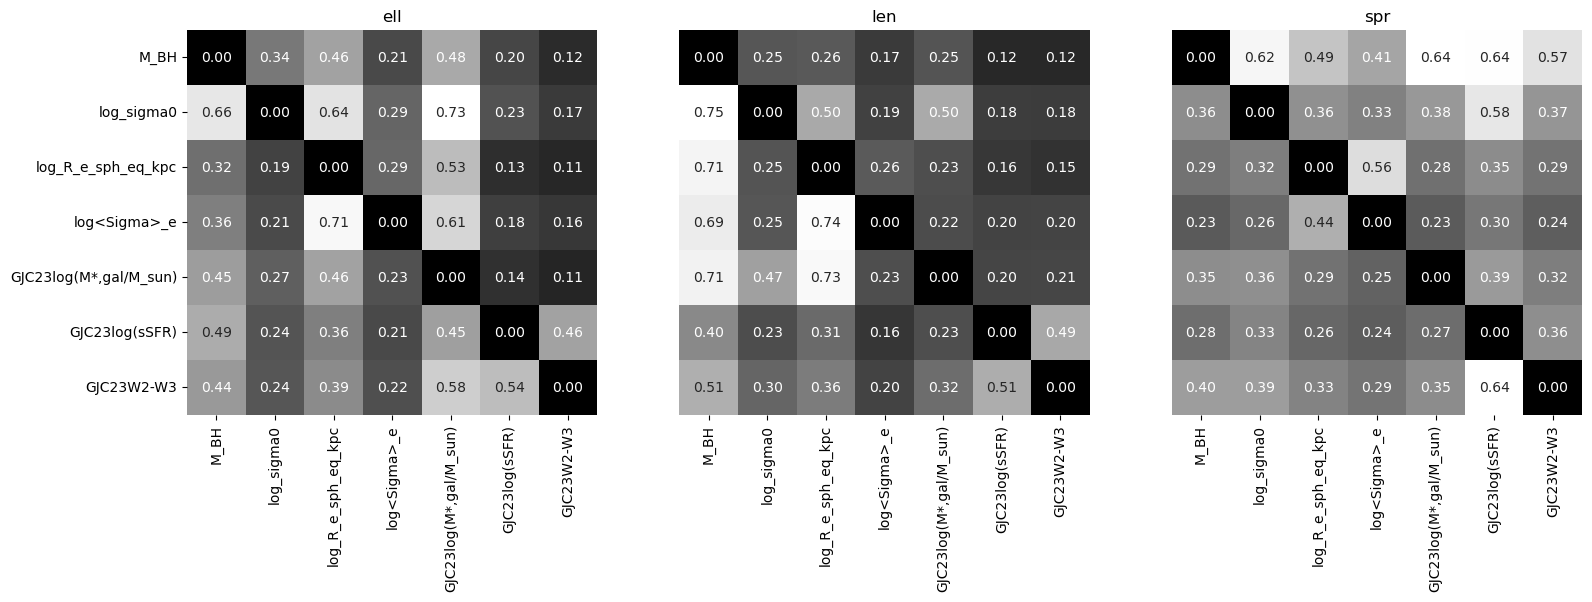

In [41]:
plt.figure(figsize=(18, 5))

for i, dataset in enumerate(datasets):
    ax = plt.subplot2grid((1, 3), (0, i))
    log_path_marginal = log_path_marginals[dataset]
    path_marginal = pd.DataFrame(np.exp(log_path_marginal),
        index=dfs[dataset].columns, columns=dfs[dataset].columns)

    sns.heatmap(path_marginal, cmap='gray', ax=ax,
                annot=path_marginal, fmt='.2f', cbar=False,
               yticklabels=i == 0)
    ax.set_title(dataset)
#plt.savefig('figures/edge_marginals.png', dpi=300)
plt.show()

In [4]:
edge_marginal_array=np.load('edge_marginal_std.npy')
path_marginal_array=np.load('path_marginal_std.npy')
# edge_marginal_array=edge_marginal_array[:33]
# path_marginal_array=path_marginal_array[:33]

labels_list = [r'$\text{M}_\bullet$',r'$\sigma_0$', r'$\text{R}_e$', r'$\Sigma_e$',
       r'$\text{M}^*$', r'$\text{sSFR}$', r'$\text{W}_2-\text{W}_3$']

galtypes = ['ell','len','spr']
typename = {'ell':'E','len':'S0','spr':'S'}

In [5]:
def plot_marginals(marginals, path=False):
    plt.figure(figsize=(36, 10))
    #cmap = cmr.neutral
    cmap='gray'

    for i, galtype in enumerate(galtypes):
        marginal=marginals[:,i,:,:]
        ax = plt.subplot(1,3,i+1)
        marginal_mean=marginal.mean(axis=0)
        marginal_std=marginal.std(axis=0)
        annot=np.empty((marginal.shape[1],marginal.shape[1]), dtype=object)

        for j in range(marginal.shape[1]):
            for k in range(marginal.shape[1]):
                annot[j,k]=str(round(marginal_mean[j,k],2))+r'$\pm$'+str(round(marginal_std[j,k],2))
        
        sns.heatmap(marginal.mean(axis=0), cmap=cmap, ax=ax,
                    annot=annot, annot_kws={"fontsize":15,'rotation':30}, fmt='', cbar=False)
        
        # for j in range(marginal.shape[1]):
        #     for k in range(marginal.shape[1]):
        #         ax.text(k+0.70,j+0.52,r'$\pm$'+str(round(marginal_std[j,k],2)),color='red',fontsize=18,fontweight='bold') #C9
        ax.set_title(typename[galtype],fontsize=35)
        ax.set_xticklabels(labels_list,rotation=45,fontsize=20)
        ax.set_yticklabels(labels_list,rotation=0,fontsize=20)
        if path:
            ax.set_xlabel('Descendant',labelpad=-10,fontsize=25)
            ax.set_ylabel('Ancestor',labelpad=-35,fontsize=25)
        else:
            ax.set_xlabel('Child',labelpad=-10,fontsize=25)
            ax.set_ylabel('Parent',labelpad=-35,fontsize=25)
    #plt.savefig('figures/edge_marginals.png', dpi=300)
    plt.show()
    return None

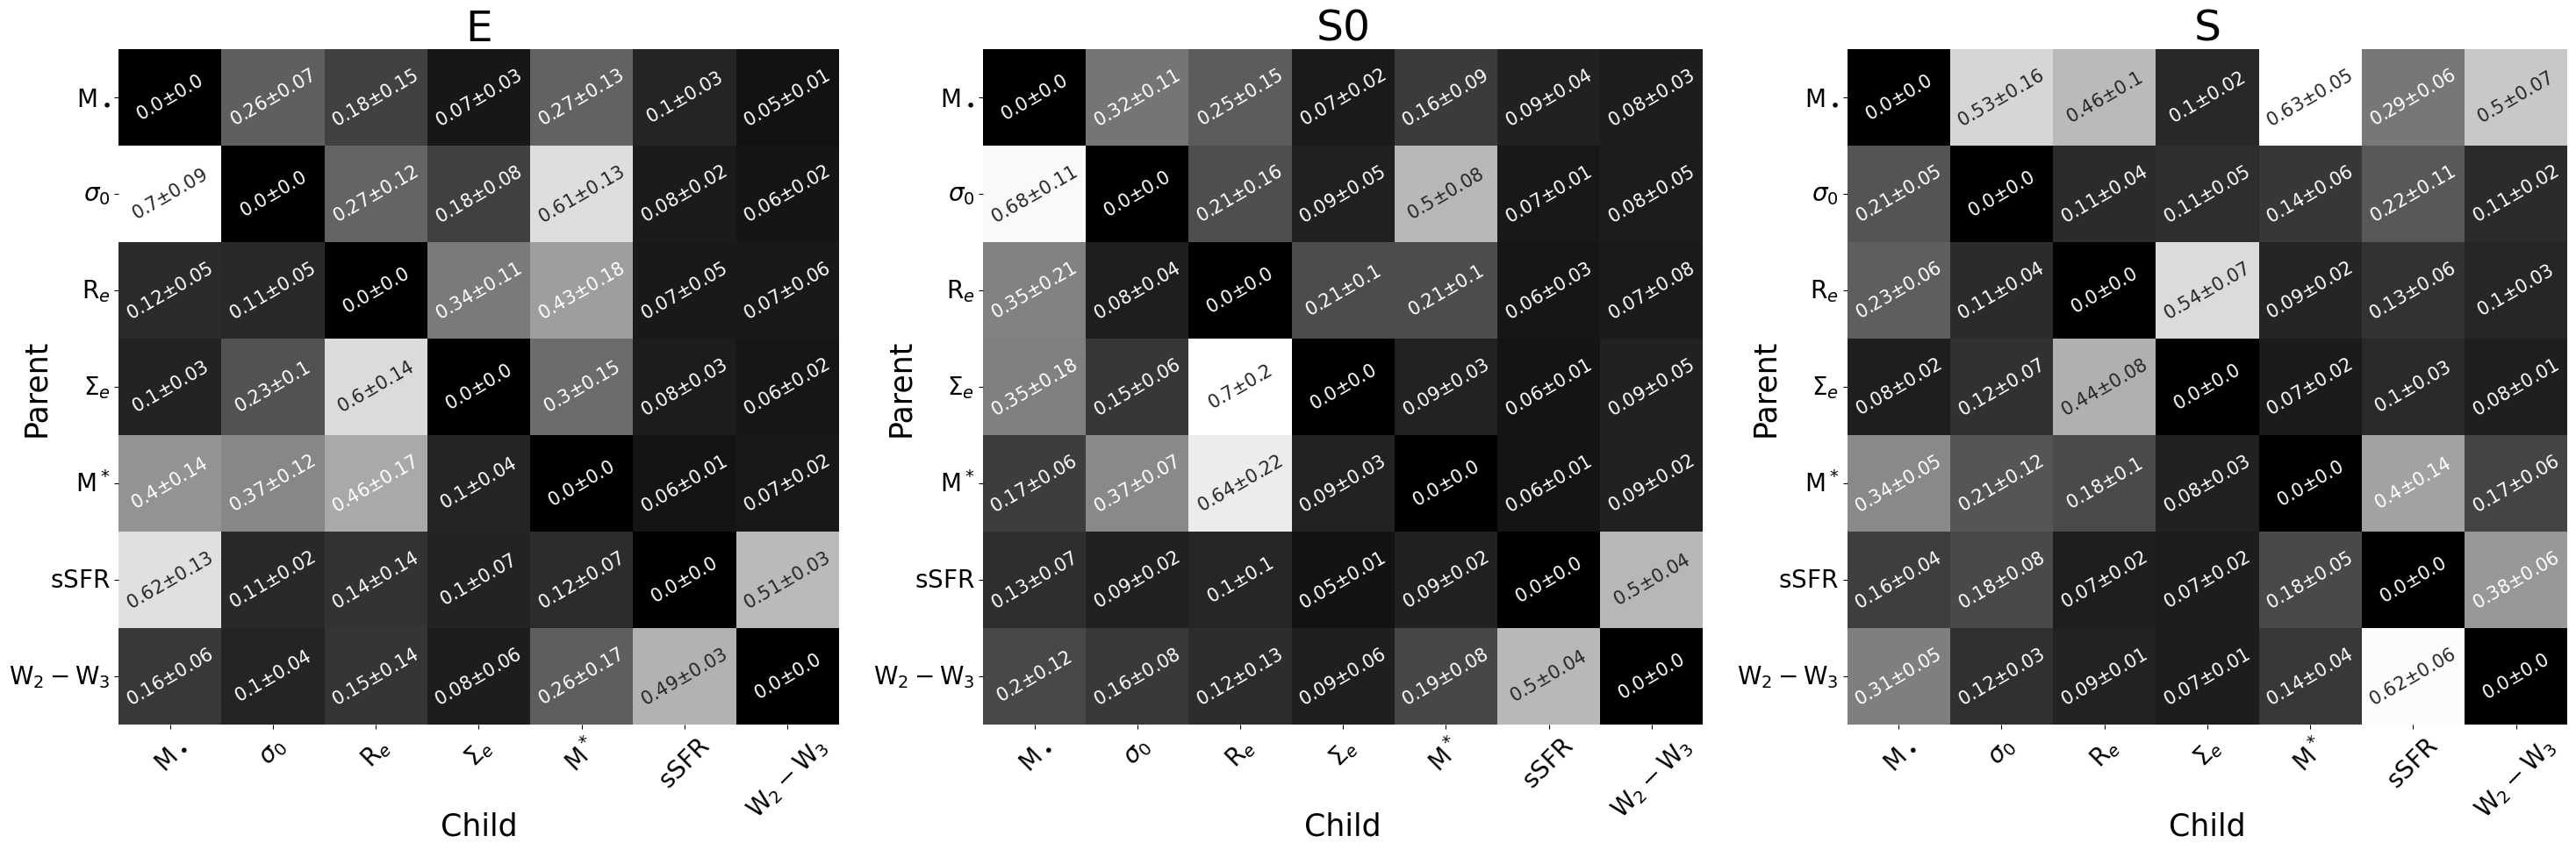

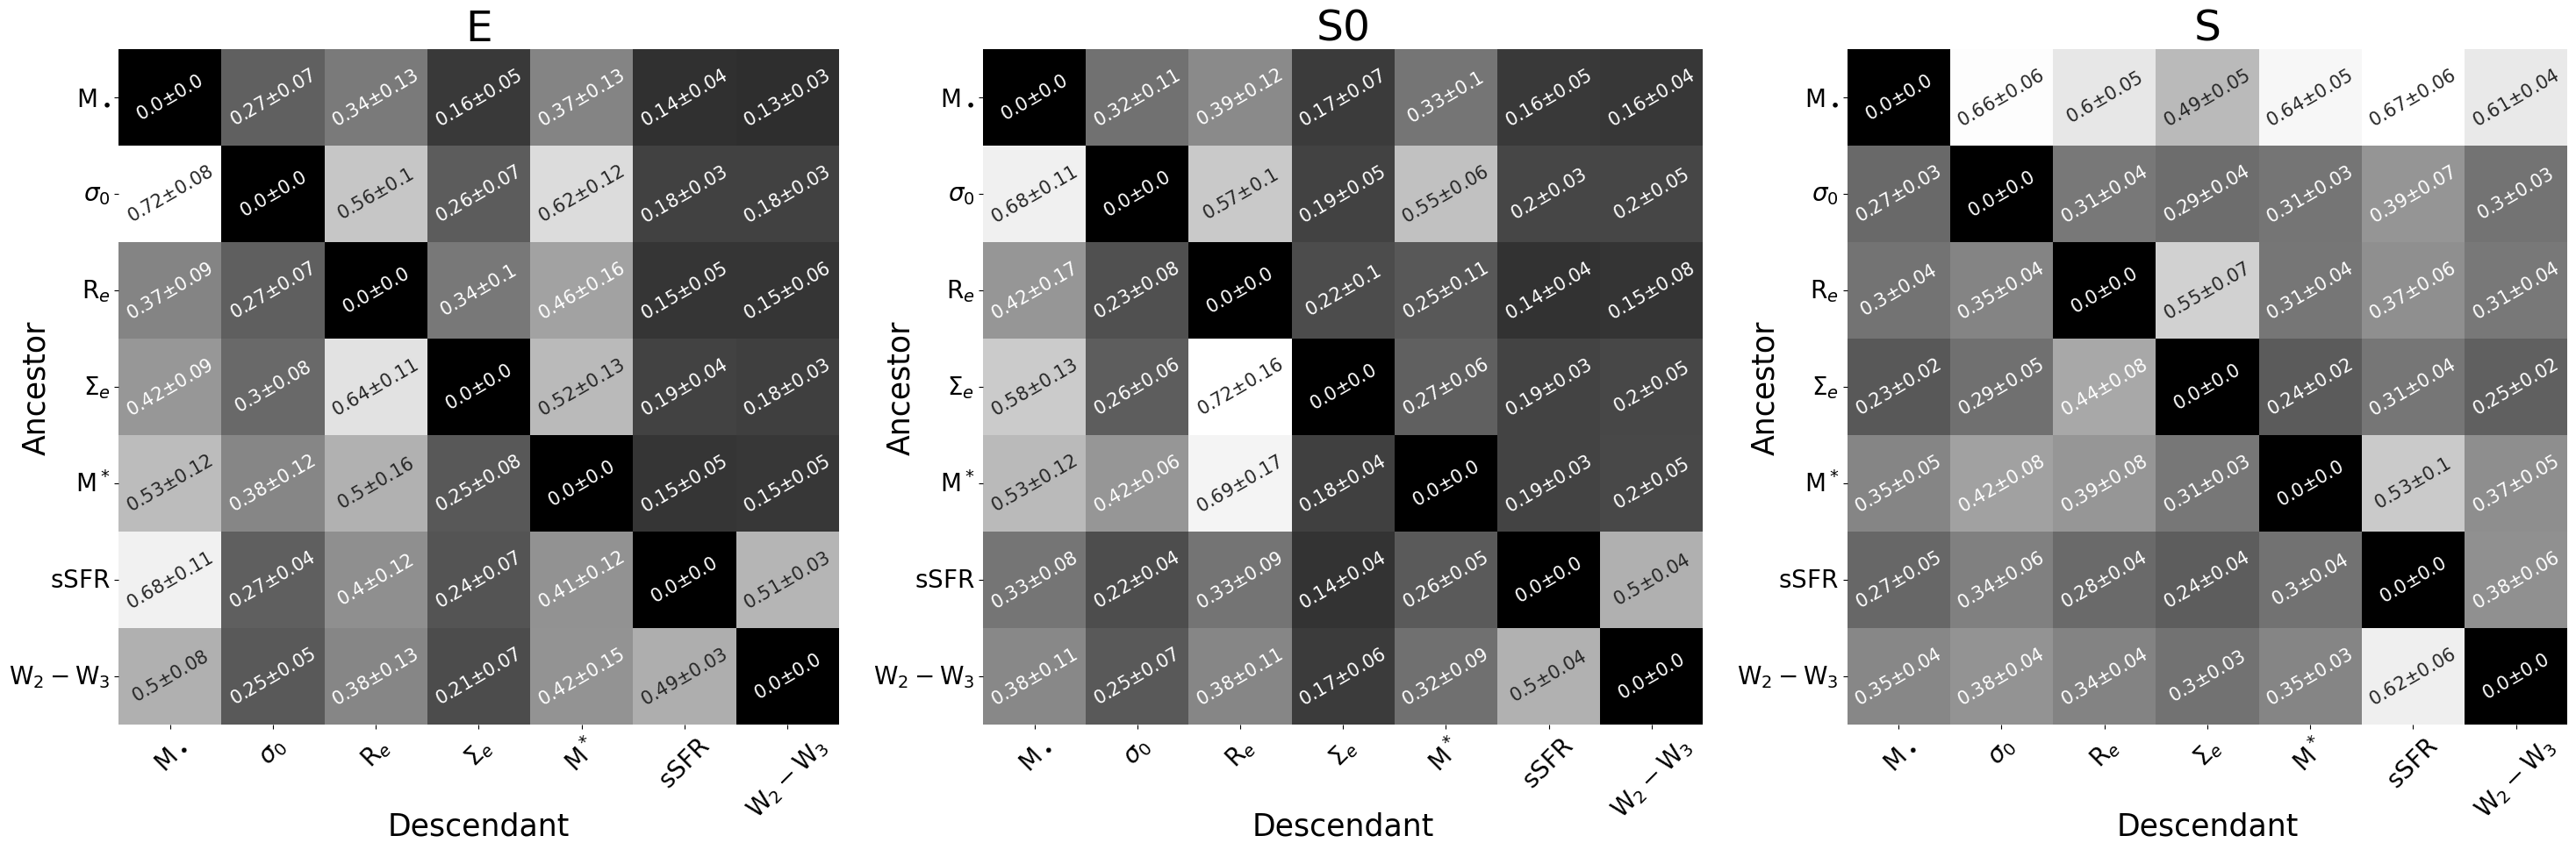

In [6]:
plot_marginals(edge_marginal_array)
plot_marginals(path_marginal_array,path=True)

In [7]:
from uncertainties import ufloat
import scipy.stats as st
from IPython.display import display, Latex

def fun(x):
    return st.norm.cdf(x)-st.norm.cdf(-x)
def inv_fun(p):
    p=p+(1.0-p)/2.
    return st.norm.ppf(p)


def cal_p(index1,index2,marginals=edge_marginal_array,marginals2=path_marginal_array,output=False):
    display(Latex(labels_list[index1]+' - '+labels_list[index2]))
    p=np.zeros((2,len(galtypes)))
    sigma=np.zeros((2,len(galtypes)))
    for i, galtype in enumerate(galtypes):
        mean=marginals[:,i,:,:].mean(axis=0)
        std=marginals[:,i,:,:].std(axis=0)

        d1=ufloat(mean[index1,index2],std[index1,index2])
        d2=ufloat(mean[index2,index1],std[index2,index1])

        sigma[0,i]=np.abs((d1-d2).n/(d1-d2).s)

        p[0,i]=1-fun(sigma[0,i])

    for i, galtype in enumerate(galtypes):
        mean=marginals2[:,i,:,:].mean(axis=0)
        std=marginals2[:,i,:,:].std(axis=0)

        d1=ufloat(mean[index1,index2],std[index1,index2])
        d2=ufloat(mean[index2,index1],std[index2,index1])

        sigma[1,i]=np.abs((d1-d2).n/(d1-d2).s)

        p[1,i]=1-fun(sigma[1,i])

    for i, galtype in enumerate(galtypes):
        print(typename[galtype],':',p[0,i]*100,'% ',p[1,i]*100,'% ',sigma[0,i],sigma[1,i])

    if output:
        return p

In [8]:
cal_p(0,1)

<IPython.core.display.Latex object>

E : 0.012070754594795119 %  0.002176951286769757 %  3.844684688733005 4.245923266768096
S0 : 1.64352469068747 %  1.6429393616285592 %  2.3991039802836522 2.3992344057278396
S : 5.419617201982296 %  5.416888493314787e-07 %  1.9252653352373112 5.833831321810488


In [15]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

def plot_single_margin(index1,index2,marginals=edge_marginal_array,marginals2=path_marginal_array,bins=5):
    color=['C1','C2','C3']
    plt.figure(figsize=(15,10))
    for i, galtype in enumerate(galtypes):
        plt.hist(marginals[:,i,index1,index2],alpha=0.7,bins=bins,histtype='step',lw=4,color=color[i])
        plt.hist(marginals2[:,i,index1,index2],alpha=0.7,bins=bins,histtype='step',lw=4,ls='--',color=color[i])
    plt.xlim(0,1)


    # Create custom legend entries
    legend_colors = [mpatches.Patch(edgecolor=color[i],fill=False,lw=4,label=typename[galtypes[i]],alpha=0.7) for i in range(len(typename))]
    legend_lines = [mlines.Line2D([], [], color='black', linewidth=4, linestyle=style,alpha=0.7, label=label) for style, label in [('-', 'Edge Marginals'), ('--', 'Path Marginals')]]

    # Combine legend entries and specify layout
    plt.legend(handles=legend_colors + legend_lines, loc=0,fontsize=25)
    plt.xlabel('marginals',fontsize=30)
    plt.ylabel('counts',fontsize=30)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(labels_list[index1]+' --> '+labels_list[index2],fontsize=30)

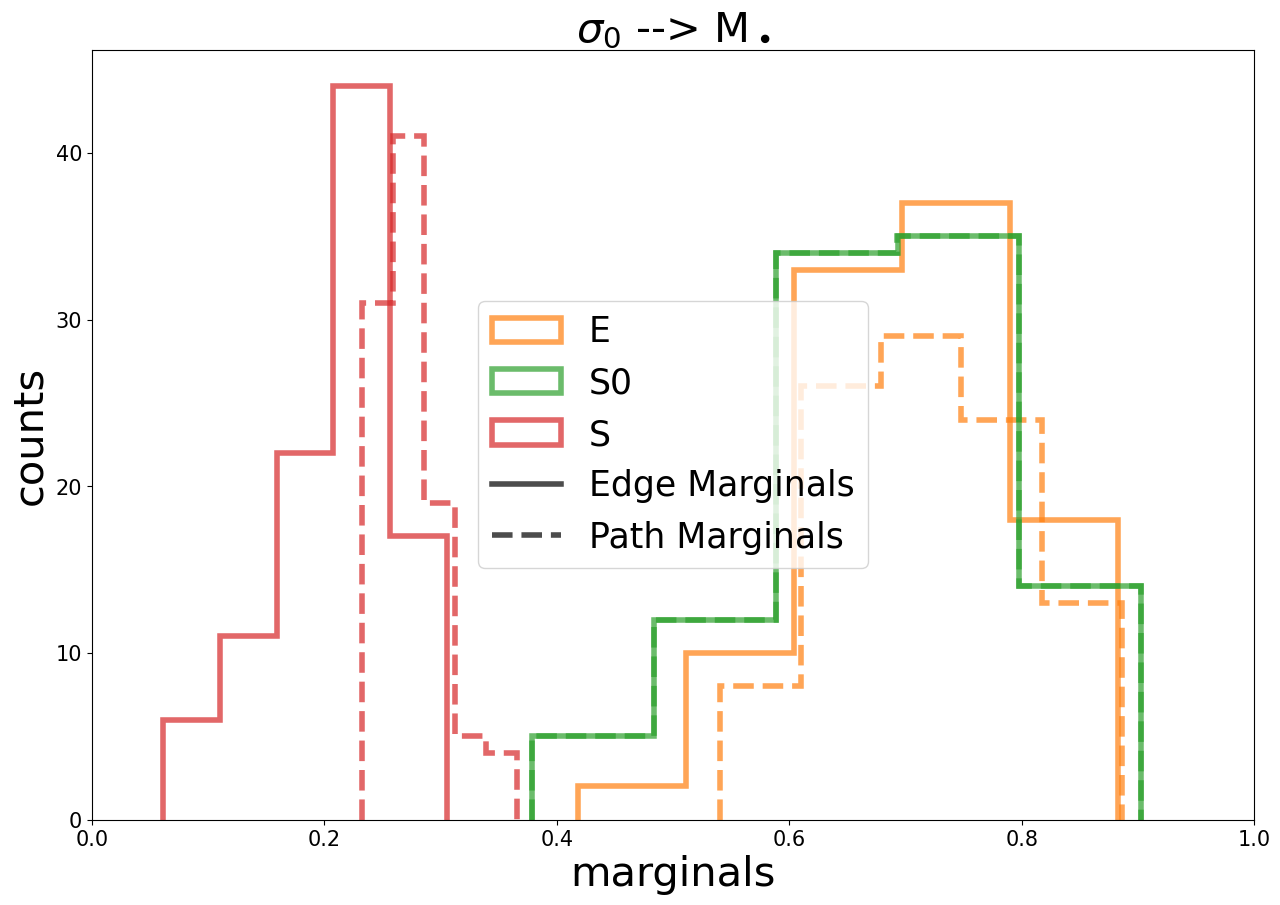

In [16]:
plot_single_margin(1,0,edge_marginal_array)
#plt.vlines(0.75,0,15)

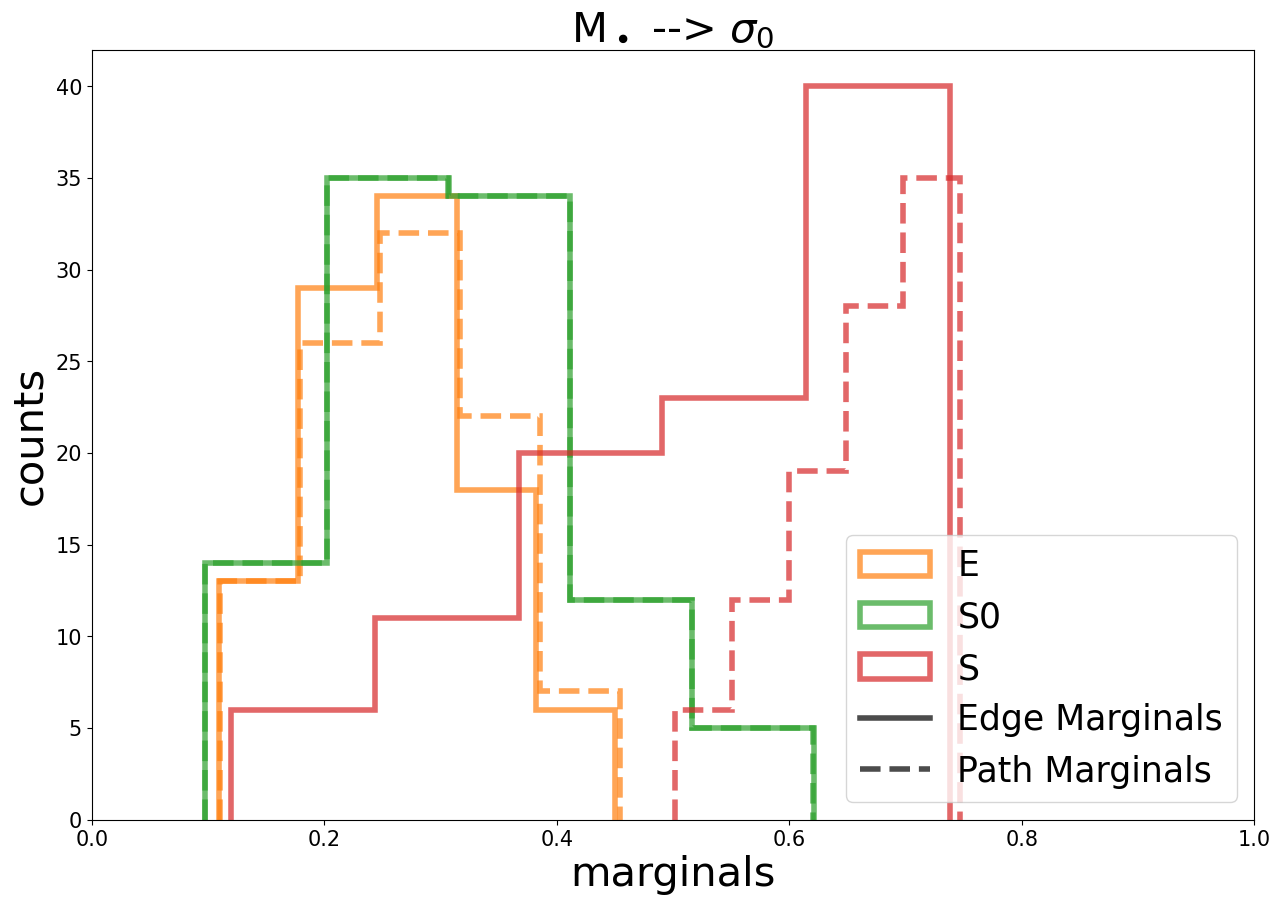

In [17]:
plot_single_margin(0,1,edge_marginal_array)
#plt.vlines(0.75,0,15,ls='dotted')